In [21]:
# inversion calculation

In [22]:
# to display plots in notebook
%matplotlib inline
%config InlineBackend.figure_format = "retina"

from matplotlib import rcParams
rcParams["savefig.dpi"] = 300  # high res plots
rcParams["font.size"] = 12

import warnings
warnings.filterwarnings('ignore')

In [23]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import re
import cartopy.crs as ccrs
from gamap_colormap import WhGrYlRd  # import the "WhGrYlRd" variable from my custom Python script

In [24]:
input_directory = '/geos/u73/msadiq/GEOS-Chem/analysis/python/data/'
output_directory = input_directory
xco2_file = 'XCO2_model.nc'
inversion_file = 'inversion.nc'

# Name of output netCDF file
output_file = 'posterior.nc'

In [25]:
ds_xco2_model = xr.open_dataset(input_directory + xco2_file)
varnames = list(ds_xco2_model.data_vars.keys())
#varnames[47:69]
#ds_xco2_model['Mar_X_SpeciesConc_CO2Tag11'].plot()

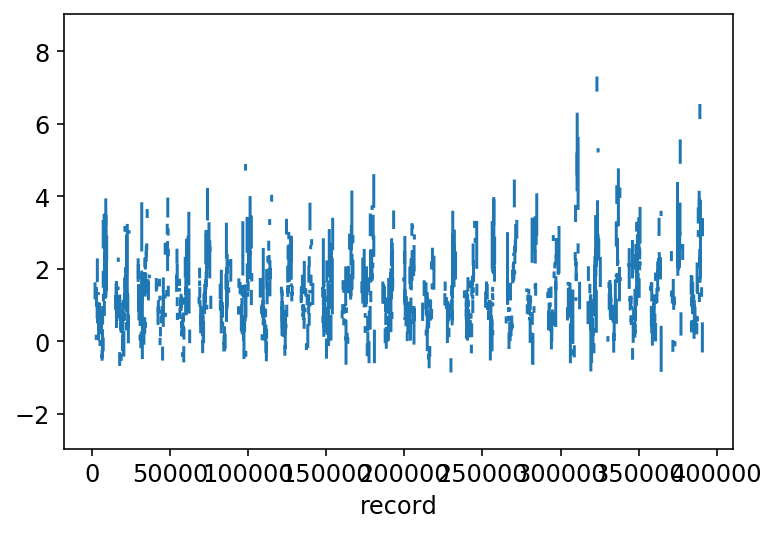

In [26]:
ds_inversion = xr.open_dataset(input_directory + inversion_file)
diff = ds_inversion['xco2_oco2'] - ds_inversion['xco2_model']
diff.plot()

In [27]:
# reduce the size of array and matrix, from 400k to 10k
xco2_oco2 = ds_xco2_model['xco2_obs']
x = xco2_oco2.copy()
x = x[np.logical_not(np.isnan(x))]
ind = x.record.values # index for slicing
length = len(ind)

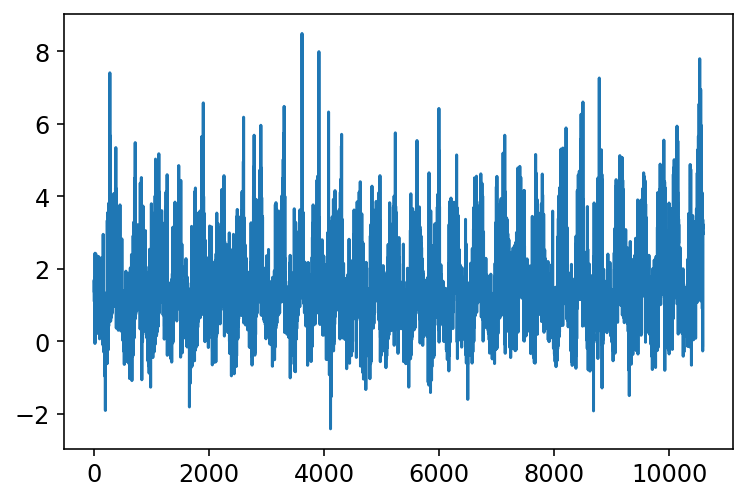

In [28]:
diff_slice = diff[ind].values
np.shape(diff_slice)
plt.plot(diff_slice) # same as above, excluded nan values

In [29]:
del_Y_matrix = np.empty((length,22))
del_Y_matrix[:] = np.nan
print(np.shape(del_Y_matrix))

for itag in range(22):
    name_var = 'Mar_X_SpeciesConc_CO2Tag' + str(itag+1)
    del_Y_matrix[:,itag] = ds_xco2_model[name_var][ind].values

(10588, 22)


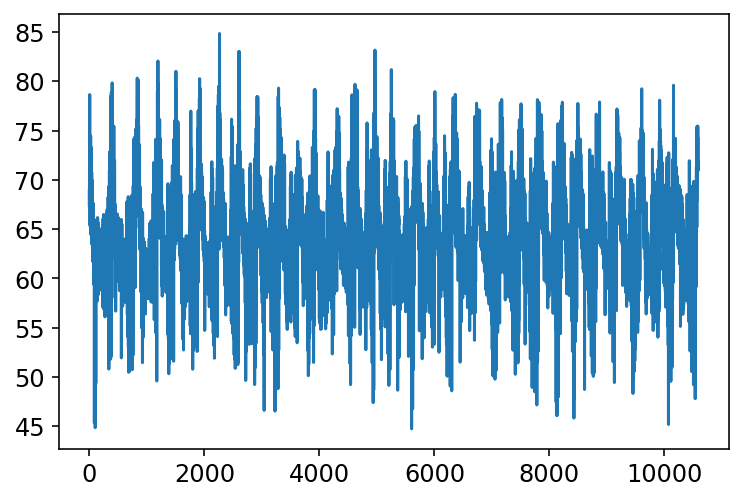

In [30]:
plt.plot(del_Y_matrix[:,0])

In [31]:
del_Y_tran = np.matrix.transpose(del_Y_matrix)
first = np.matmul(del_Y_matrix,del_Y_tran)
print(np.shape(first))

random_error = np.random.random_sample(length)
#random_error = np.random.randn(length)
obs_error = np.empty((length,length))
print(np.shape(obs_error))
for idiag in range(length):
    obs_error[idiag, idiag] = random_error[idiag]
obs_error

(10588, 10588)
(10588, 10588)


array([[0.12009937, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.32590162, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.1078143 , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.54089744, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.71139634,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.10864801]])

In [32]:
second = np.linalg.inv(first+obs_error)
second

array([[ 8.32276976e+00, -1.30476666e-03, -4.26210940e-03, ...,
         3.13283922e-04,  8.61841251e-05, -3.77330371e-04],
       [-1.30476673e-03,  3.06794656e+00, -1.51597210e-03, ...,
         1.11407431e-04,  3.02427691e-05, -1.37095521e-04],
       [-4.26210932e-03, -1.51597185e-03,  9.27025493e+00, ...,
         3.64026719e-04,  1.00548008e-04, -4.35539513e-04],
       ...,
       [ 3.13283687e-04,  1.11407429e-04,  3.64026636e-04, ...,
         1.83442435e+00, -4.89570208e-03, -7.74397712e-03],
       [ 8.61843436e-05,  3.02428365e-05,  1.00548217e-04, ...,
        -4.89570182e-03,  1.40388865e+00, -3.66849801e-03],
       [-3.77329737e-04, -1.37095156e-04, -4.35538929e-04, ...,
        -7.74397834e-03, -3.66849761e-03,  9.19124557e+00]])

In [33]:
third = np.matmul(del_Y_tran,second)
#plt.plot(third)
np.shape(third)

(22, 10588)

In [34]:
random_error = np.random.random_sample(22)
random_error

array([5.31799226e-01, 4.04666654e-01, 8.28137594e-02, 2.02417723e-01,
       4.00239590e-01, 5.60008951e-02, 4.19581515e-01, 7.43431664e-01,
       2.97640987e-01, 2.31906936e-01, 2.29608721e-01, 7.23937611e-01,
       6.01500600e-01, 4.57038633e-01, 5.40206822e-01, 3.24084093e-01,
       5.31038385e-01, 8.51956235e-01, 1.70456443e-01, 1.65021739e-01,
       1.96431056e-04, 3.71806787e-01])

In [35]:
#random_error = np.random.random_sample(22)
del_X_f = np.zeros((22,22))
for idiag in range(22):
    del_X_f[idiag,idiag] = 1.0/21 # GrC/yr
#del_X_f

In [36]:
k_e = np.matmul(del_X_f,third)
np.shape(k_e)

(22, 10588)

In [37]:
region_names = ['Australia',
 'Amazon Basin',
 'Southern South America',
 'Central America',
 'Western North America',
 'Central North America',
 'Eastern North America',
 'Alaska',
 'Greenland',
 'Mediterranean Basin',
 'Northern Europe',
 'Western Africa',
 'Eastern Africa',
 'Southern Africa',
 'Sahara',
 'Southeast Asia',
 'East Asia',
 'South Asia',
 'Central Asia',
 'Tibet',
 'North Asia',
 'Ocean']

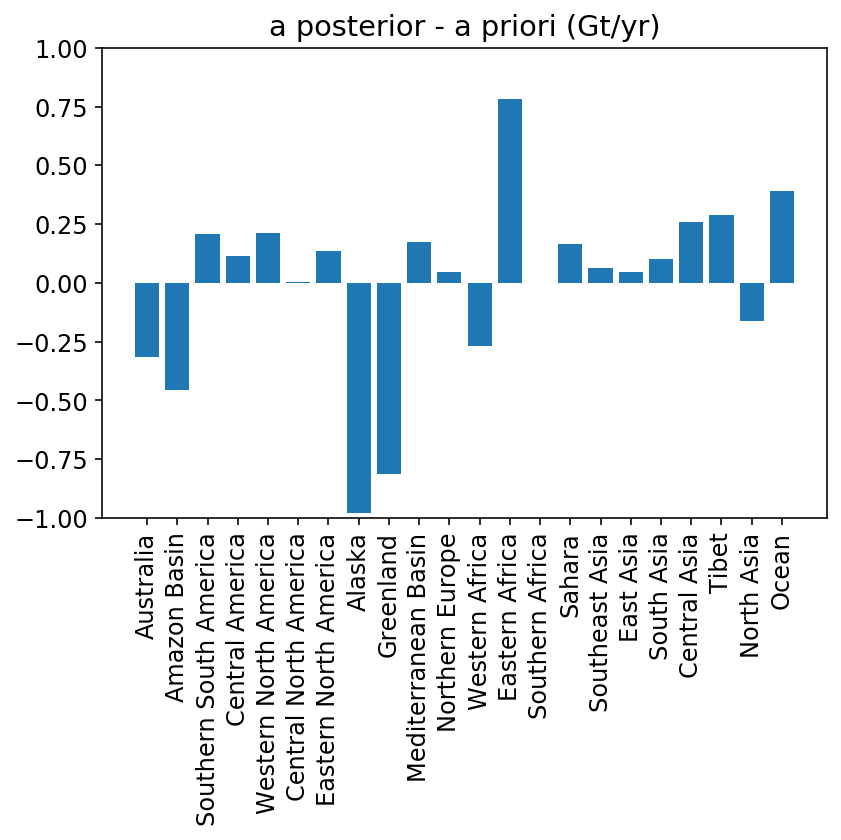

In [41]:
adjust = np.matmul(k_e, diff_slice)

fig = plt.figure(figsize=[6, 6])
plt.bar(region_names, adjust)
plt.ylim(top   = 1,bottom = -1)
plt.title('a posterior - a priori (Gt/yr)')
plt.xticks(rotation=90)
fig.tight_layout()

fig.savefig(output_directory+'adjustment.png', dpi=300)

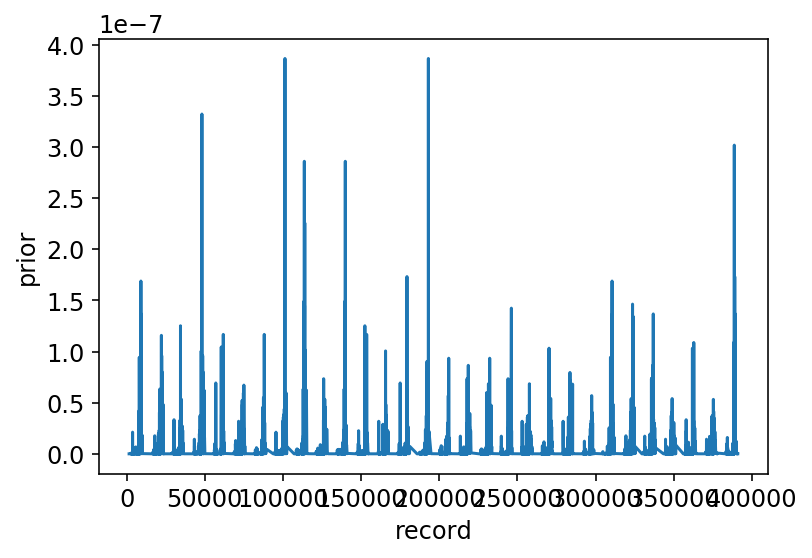

In [39]:
ds_inversion['prior'][ind].plot()